## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
import torch
import sys
import os
from torch.utils.data import DataLoader, random_split
import wandb
import random
import datetime

current_dir = os.path.dirname(os.path.abspath(''))
two_up_dir = os.path.dirname(os.path.dirname(current_dir))
sys.path.append(two_up_dir)

from CenterSpeed.src.models.resnet import *
from CenterSpeed.src.models.CenterSpeed import *
from CenterSpeed.dataset.CenterSpeed_dataset import *
from CenterSpeed.src.models.losses import *
from train import *


# %env "WANDB_NOTEBOOK_NAME" "centerspeed.ipynb"
# print(wandb.__version__)
# wandb.login()

## Load Data

In [2]:
def cartesian_to_pixel(x, y, image_size=[64,64], pixel_size=0.1):
    pixel_x = int(x / pixel_size + image_size[0] / 2)
    pixel_y = int(y / pixel_size + image_size[1] / 2)
    return pixel_x, pixel_y

transform = transforms.Compose([RandomRotation(45),
                                RandomFlip(0.5)])

set = CenterSpeedDataset('../../dataset/data/CenterSpeedDataset', transform=None, dense=True)
set.seq_len = 2
set.sx = 0.9
set.sy = 0.9
set.change_image_size(64)
set.change_pixel_size(0.1)

independent_test_set = LidarDatasetSeqOD('../../dataset/data/validation_set.csv')
independent_test_set.seq_len = 2

# set.visualize(12)#visualize the dataset
# for i in range(10000):
#     input, gt_heatmap, data, dense_data, is_free = set[i]
#     if is_free:
#         print(f'Free space found at index {i}')
#         break



Reading the following files:  ../../dataset/data/CenterSpeedDataset/25_04_Dataset02_FTG_10s.csv
Number of entries:  349
Reading the following files:  ../../dataset/data/CenterSpeedDataset/25_04_Dataset01_FTG_10s.csv
Number of entries:  341
Reading the following files:  ../../dataset/data/CenterSpeedDataset/16_05_Dataset04.csv
Number of entries:  386
Reading the following files:  ../../dataset/data/CenterSpeedDataset/16_05_Dataset06_manual2.csv
Number of entries:  398
Reading the following files:  ../../dataset/data/CenterSpeedDataset/06_04_Dataset04.csv
Number of entries:  1278
Reading the following files:  ../../dataset/data/CenterSpeedDataset/06_04_Dataset03.csv
Number of entries:  1278
Reading the following files:  ../../dataset/data/CenterSpeedDataset/25_04_Dataset04_10s.csv
Number of entries:  350
Reading the following files:  ../../dataset/data/CenterSpeedDataset/25_04_Dataset03_10s.csv
Number of entries:  350
Reading the following files:  ../../dataset/data/CenterSpeedDataset/06

Using dense features with data: tensor([ 0.8043,  0.5594,  0.8292, -0.8334,  0.7879])
Data length: 5
Data: GT


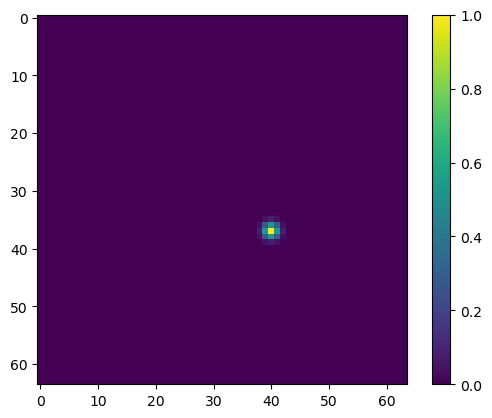

Dense data shape: torch.Size([64, 64, 3])
Data: VX
Maximum from data: 0.8291579484939575
Maximum value in image slice 0: 0.8291579484939575
Minimum value in image slice 0: 0.0


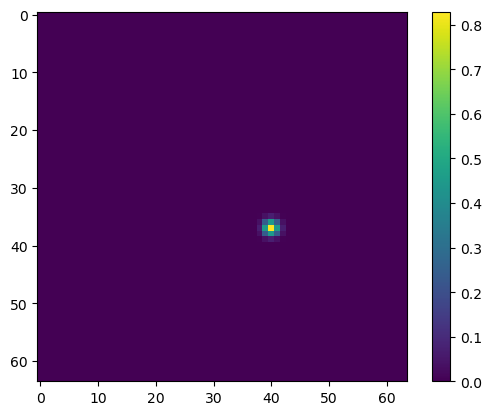

Data: VY
Maximum from data: -0.8333555459976196
Maximum value in image slice 1: -0.0
Minimum value in image slice 1: -0.8333555459976196


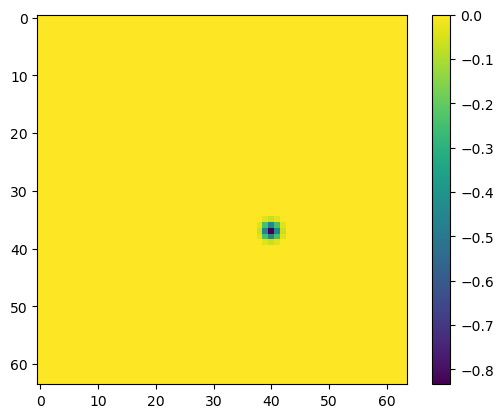

Data: YAW
Maximum from data: 0.7879230380058289
Maximum value in image slice 2: 0.7879230380058289
Minimum value in image slice 2: 0.0


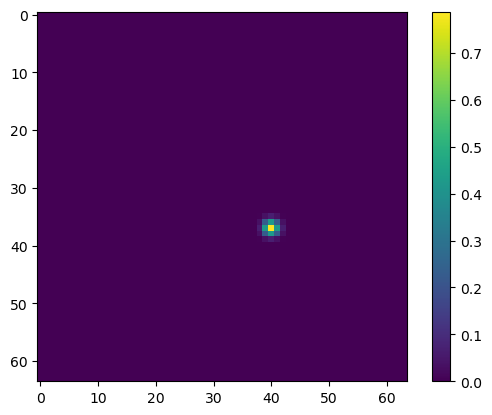

In [3]:
input, gt_heatmap, data, dense_data, is_free = set[10]

print(f'Data: GT')
plt.imshow(gt_heatmap)
plt.colorbar()
plt.show()

labels = ['VX', 'VY', 'YAW']
print(f'Dense data shape: {dense_data.shape}')

for i in range(dense_data.shape[2]):
    plt.imshow(dense_data[:,:,i])
    print(f'Data: {labels[i]}')
    print(f'Maximum from data: {data[i+2].item()}')
    # Extract and print the maximum value
    max_value = np.max(dense_data[:,:,i].numpy().flatten())
    min_value = np.min(dense_data[:,:,i].numpy().flatten())
    print(f"Maximum value in image slice {i}: {max_value}")
    print(f"Minimum value in image slice {i}: {min_value}")
    plt.colorbar()
    plt.show()



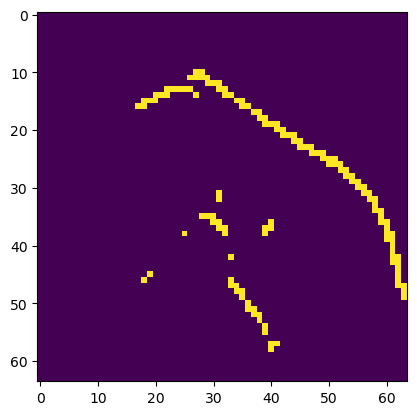

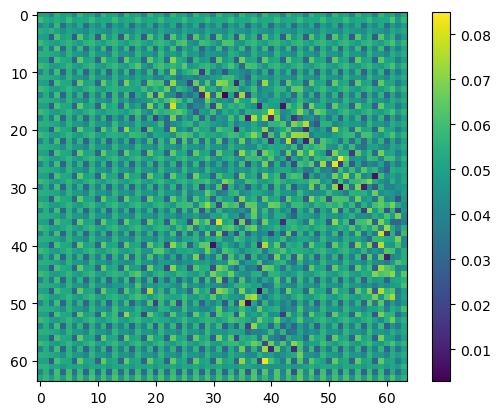

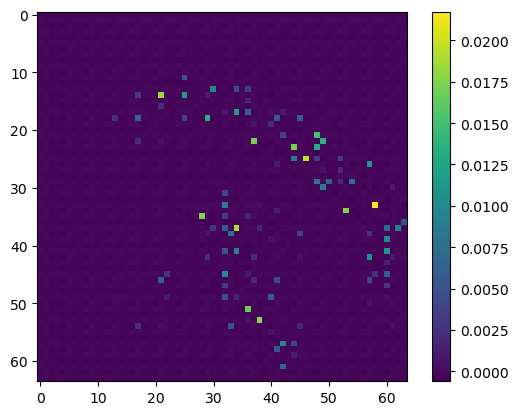

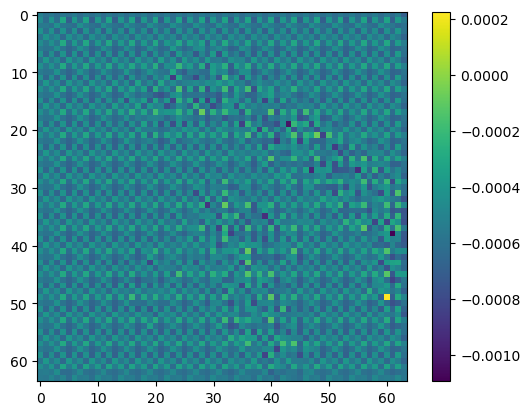

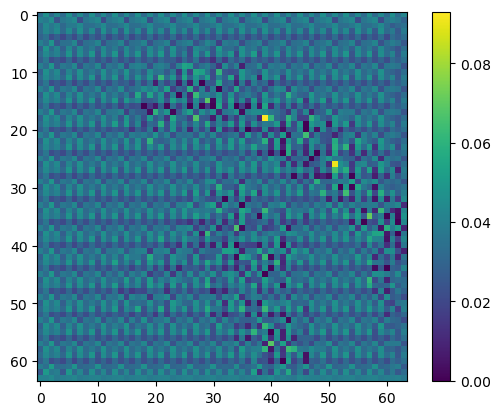

In [4]:
### TEST THE MODEL

model = CenterSpeedDense()
model.eval()

output = model(input.unsqueeze(0))

plt.imshow(input[0])
plt.show()
for i in range(output.shape[1]):
    plt.imshow(output[0,i].detach().numpy())
    plt.colorbar()
    plt.show()

Output Shape: torch.Size([1, 4, 64, 64])


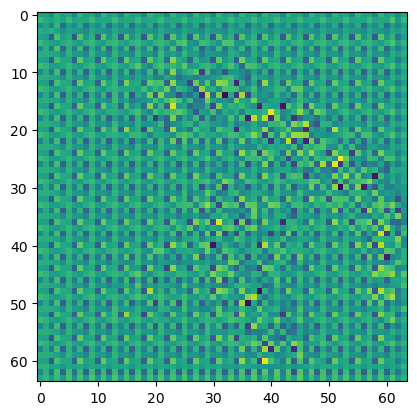

Output Shape: torch.Size([1, 64, 64, 4])
GT Heatmap Shape: torch.Size([1, 64, 64, 1])
GT Dense Shape: torch.Size([1, 64, 64, 3])


In [5]:
### new Loss funcction

def dense_loss(output, gt_heatmap, gt_dense_data, is_free, alpha=0.7, decay=1):
    print(f'Output Shape: {output.shape}')
    print(f'GT Heatmap Shape: {gt_heatmap.shape}')
    print(f'GT Dense Shape: {gt_dense_data.shape}')
    # fig, ax = plt.subplots(1,3, figsize=(15,5))
    # ax[0].imshow(gt_heatmap[0])
    # ax[0].set_title('GT Heatmap')
    # ax[1].imshow(gt_dense_data[:,:,:,0].squeeze())
    # ax[1].set_title('GT Dense Data')
    # ax[2].imshow(output[0,:,:,0].squeeze().detach().numpy())


    loss = 0
    batch_size = output.shape[0]

    w = gt_heatmap # unit heatmap

    loss += (alpha * (1+w)* (output[:,:,:,0].unsqueeze(-1) - gt_heatmap)**2).sum()
    loss += ((1-alpha) * (1+w)* (output[:,:,:,1:] - gt_dense_data)**2).sum()

    return loss/ batch_size
print(f'Output Shape: {output.shape}')
plt.imshow(output[0,0].detach().numpy())
plt.show()
loss = dense_loss(output.permute(0,2,3,1), gt_heatmap.unsqueeze(0).unsqueeze(-1), dense_data.unsqueeze(0), is_free)
# print(f'Loss: {loss.item()}')

## Parameter Definition

In [6]:
use_wandb = False
save_code = True
# Define the hyperparameters, logged in wandb
epochs = 15
learning_rate = 5e-4
learning_rate_hm = 0.005
learning_rate_head = 0.005
architecture = "CenterSpeed: Hourglass Deep with Sigmoid, & Dropout, BatchNorm and Head with 2 frames, lower resolution: 64x64, pixelsize 0.1"
dataset = "Transfer learning test"
optimizer = "Adam"
batch_size = 32
timer = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_name = "CenterSpeed_" + timer
loss_used = "CenterSpeedLossFreev2 with updated logic for free tracks on the dataset level"

#wandb configurations
config = {
    "epochs": epochs,
    "learning_rate": learning_rate,
    "architecture": architecture,
    "dataset": dataset,
    "optimizer": optimizer,
    "Loss-Function": loss_used
}
if use_wandb:
    #initialize wandb run
    run = wandb.init(project="CenterSpeedLowRes", config=config, name=run_name, save_code=save_code)#initialize wandb



train_size = int(len(set) * 1)  # 80% for training
val_size = int(len(set) * 0)  # 0% for validation since this set is seperate!
test_size = len(set) - (train_size + val_size)  # Remaining 5% for testing

train_dataset, val_dataset, test_dataset = random_split(set, [train_size, val_size, test_size])


training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
validation_loader = DataLoader(independent_test_set, batch_size=batch_size, shuffle= False)

print("Size of Training Set: ", len(train_dataset))
print("Size of Testing Set: ", len(test_dataset))
print("Size of Validation Set: ", len(val_dataset))

net = CenterSpeedDense(image_size=64)

optimizer = torch.optim.Adam(net.parameters(), lr= learning_rate)
print("Optimizer Initialized")

loss_fn = dense_loss
print("Loss function initialized")

Size of Training Set:  15347
Size of Testing Set:  0
Size of Validation Set:  0
Optimizer Initialized
Loss function initialized


In [7]:
def print_learning_rates(optimizer):
    for i, param_group in enumerate(optimizer.param_groups):
        print(f"Learning rate of layer {i}: {param_group['lr']}")

print_learning_rates(optimizer)

net.train()

for name, param in net.named_parameters():
    if param.requires_grad:
        print("GRAD: ", name)
    else:
        print("NO GRAD: ", name)

Learning rate of layer 0: 0.0005
GRAD:  conv1.weight
GRAD:  conv1.bias
GRAD:  bn1.weight
GRAD:  bn1.bias
GRAD:  conv2.weight
GRAD:  conv2.bias
GRAD:  bn2.weight
GRAD:  bn2.bias
GRAD:  deconv1.weight
GRAD:  deconv1.bias
GRAD:  deconv2.weight
GRAD:  deconv2.bias
GRAD:  bn4.weight
GRAD:  bn4.bias
GRAD:  bn3.weight
GRAD:  bn3.bias


## Training

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
from IPython.display import clear_output, display


def train_epoch_Centerspeed_dense(training_loader, net, optimizer, loss_fn, device = 'cpu', use_wandb=False, pdf=None):
    running_loss = 0.
    last_loss = 0.

    plt.ion()
    fig, ax = plt.subplots(1,3, figsize=(15,5))

    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, gts, data, dense_data, is_free = data
        inputs = inputs.to(device)
        gts = gts.to(device)
        data = data.to(device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        output = net(inputs)
        # Compute the loss and its gradients

        loss = loss_fn(output.permute(0,2,3,1), gts.unsqueeze(-1), dense_data, is_free)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        last_loss = loss.item() # loss per batch

        ##Plot the input, output and ground truth in a interactive plot
        for a in ax:
            a.clear()
        ax[0].imshow(inputs[0,0])
        ax[0].set_title('Input')
        ax[1].imshow(output[0,0].detach().numpy())
        ax[1].set_title('Output')
        ax[2].imshow(gts[0])
        ax[2].set_title('Ground Truth')
        print(np.max(output[0,0].detach().numpy()))
        clear_output(wait=True)
        display(fig)


        print('  batch {} loss: {}'.format(i + 1, last_loss))
        if use_wandb:
            wandb.log({"batch_loss": last_loss/len(inputs)})#log the average loss per batch

    plt.show()
    return last_loss



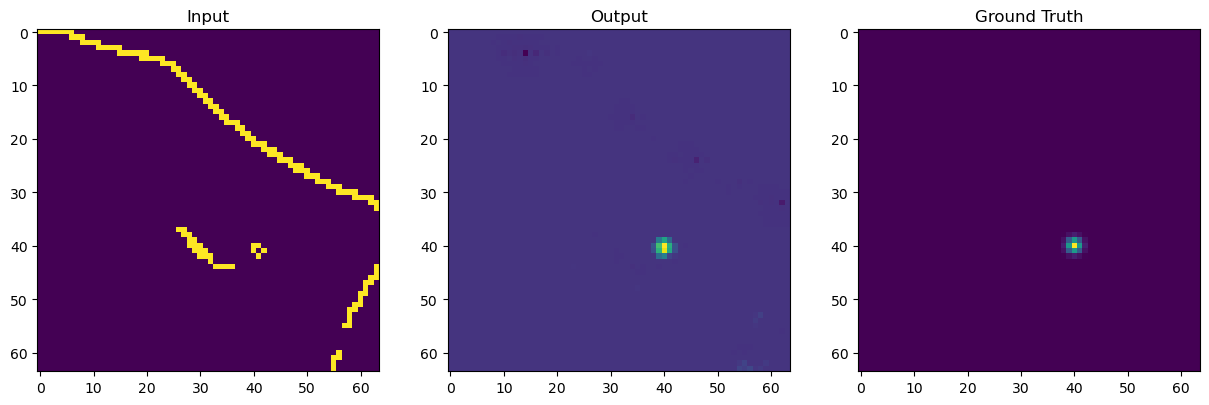

  batch 32 loss: 1.8170291185379028
Using dense features with data: tensor([ 0.9757,  0.3014,  0.6537, -0.5958,  0.7392])
Data length: 5
Using dense features with data: tensor([ 1.2645, -0.2155,  1.4027,  0.2516, -0.1775])
Data length: 5
Using dense features with data: tensor([ 1.0968,  0.1753,  1.4799, -0.9628,  0.5768])
Data length: 5
Using dense features with data: tensor([-1.8760,  2.1582, -0.6957,  1.2992, -2.0624])
Data length: 5
Car Behind, setting zero
Using dense features with data: tensor([ 1.3433,  0.5241,  1.4051, -1.1037,  0.6658])
Data length: 5
Using dense features with data: tensor([ 0.7873,  0.3926,  0.3703, -0.5200,  0.9520])
Data length: 5
Using dense features with data: tensor([ 1.2107,  0.0041,  1.4959, -1.8389,  0.8879])
Data length: 5
Using dense features with data: tensor([ 2.6531,  0.9958,  1.6810, -2.3417,  0.9482])
Data length: 5
Using dense features with data: tensor([-1.7163,  0.4214,  1.9934,  1.4041, -0.6137])
Data length: 5
Car Behind, setting zero
Using

KeyboardInterrupt: 

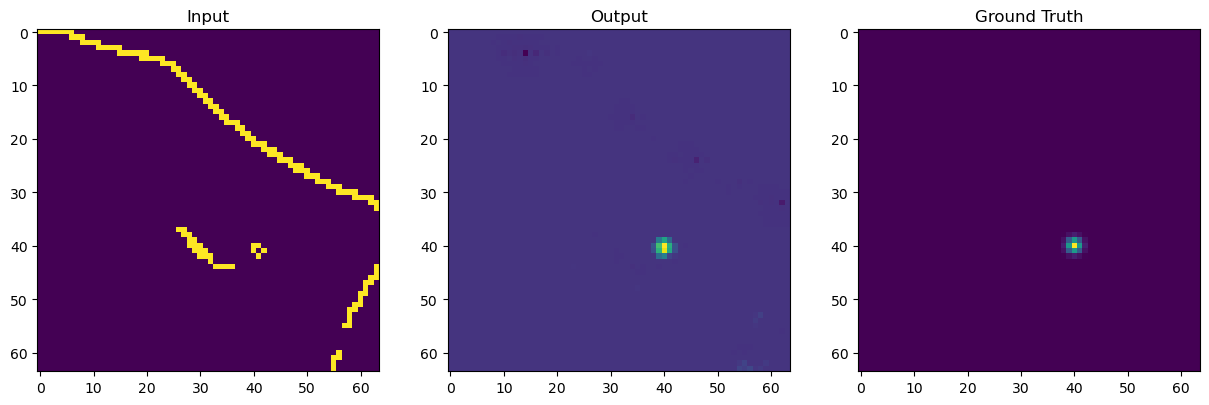

In [10]:



# Initializing in a separate cell so we can easily add more epochs to the same run
#net, optimizer, loss_fn, training_loader, validation_loader = initialize(config)
net.to(device)

EPOCHS = 10000
losses = []


for epoch in range(EPOCHS):
    print('Epoch: ', epoch)
    net.train()
    avg_loss = train_epoch_Centerspeed_dense(training_loader=training_loader, net=net, optimizer=optimizer,loss_fn=loss_fn, device=device, use_wandb=False)

    losses.append(avg_loss)

    #save the model
    if epoch % 10 == 0:
        model_path = '../trained_models/dense_epoch_' + str(epoch) + '.pt'
        torch.save(net.state_dict(), model_path)
        #wandb.save(model_path)


plt.plot(losses)
plt.show()

In [ ]:
for name, param in net.named_parameters():
    if param.grad is None:
        print(name, param.data)
    if param.grad is not None:
        print(name)



conv1.weight
conv1.bias
bn1.weight
bn1.bias
conv2.weight
conv2.bias
bn2.weight
bn2.bias
deconv1.weight
deconv1.bias
deconv2.weight
deconv2.bias
bn3.weight
bn3.bias


In [24]:
input = next(iter(training_loader))[0]

import time
start = time.perf_counter()
output = net(input)
end = time.perf_counter()
print(f'Elapsed time: {(end-start)*1000} ms')
print(f'Input Shape: {input.shape}')
print(f'Output Shape: {output.shape}')

input, gt_heatmap, data, dense_data, is_free = set[100]
output = net(input.unsqueeze(0))

Using dense features with data: tensor([ 1.1134, -0.6204,  1.0402,  1.5045, -0.9659])
Data length: 5
Using dense features with data: tensor([ 1.1130,  0.4594,  1.1785, -1.3884,  0.8670])
Data length: 5
Using dense features with data: tensor([ 1.8351,  0.3664,  1.5198,  1.5692, -0.8014])
Data length: 5
Using dense features with data: tensor([-1.4373,  2.5432, -0.8389,  1.6953, -2.0303])
Data length: 5
Car Behind, setting zero
Using dense features with data: tensor([ 0.6348,  0.1582,  1.8488, -0.8483,  0.4302])
Data length: 5
Using dense features with data: tensor([ 1.0427, -0.5161,  1.1381,  1.3100, -0.8555])
Data length: 5
Using dense features with data: tensor([ 0.9200,  0.4273,  1.3571, -1.0669,  0.6663])
Data length: 5
Using dense features with data: tensor([ 1.1474,  0.5193,  2.2853, -2.0849,  0.7396])
Data length: 5
Using dense features with data: tensor([-1.7642,  0.5028,  1.6271,  1.5867, -0.7729])
Data length: 5
Car Behind, setting zero
Using dense features with data: tensor([ 

In [25]:

print(output.shape)

torch.Size([1, 4, 64, 64])


Using dense features with data: tensor([ 1.7890,  0.4868,  1.6484, -1.1672,  0.6161])
Data length: 5


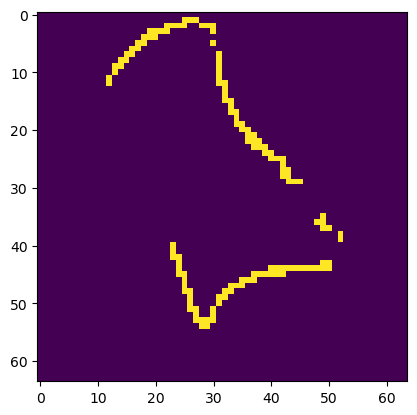

tensor([ 1.7890,  0.4868,  1.6484, -1.1672,  0.6161])


/tmp/ipykernel_31963/1572689904.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output[0,0] = F.softmax(output[0,0])


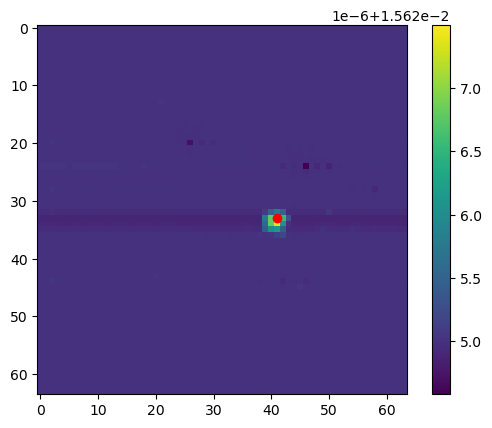

Output: Heatmap


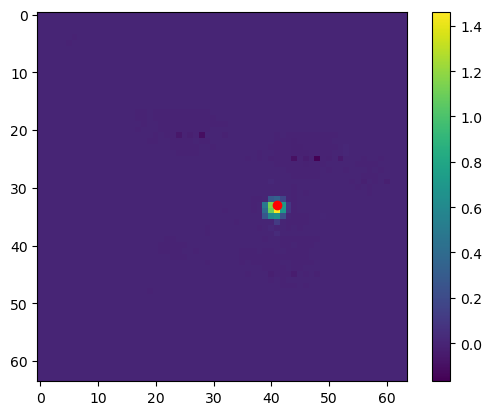

GT: 1.6484249830245972 
Output: 1.461930513381958 
Maximum value in image slice 1: 1.461930513381958
Minimum value in image slice 1: -0.16794909536838531


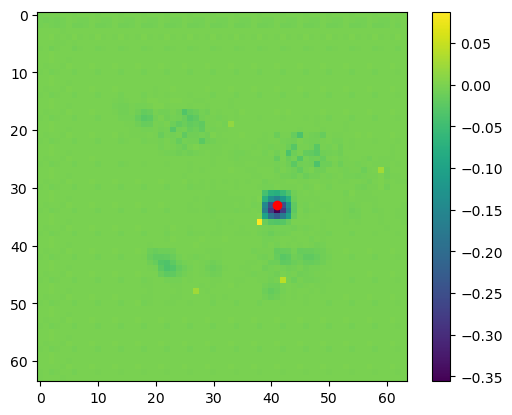

GT: -1.167177438735962 
Output: -0.3313658535480499 
Maximum value in image slice 2: 0.08763760328292847
Minimum value in image slice 2: -0.3558923006057739


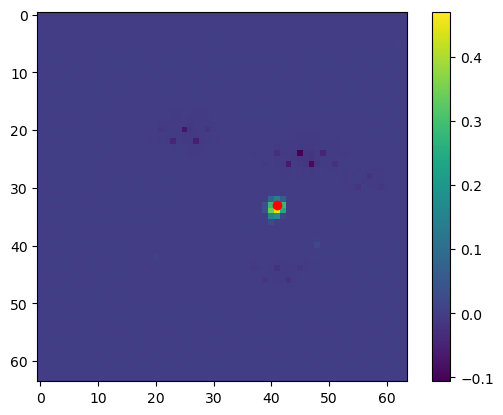

GT: 0.6161122918128967 
Output: 0.47038429975509644 
Maximum value in image slice 3: 0.47038429975509644
Minimum value in image slice 3: -0.1063111275434494


In [35]:
input, gt_heatmap, data, dense_data, is_free = set[np.random.randint(0, len(set))]
input = input.unsqueeze(0)

plt.imshow(input[0,0])
plt.show()
max_index = np.unravel_index(output[0,0].detach().numpy().argmax(), output[0,0].shape)
output[0,0] = F.softmax(output[0,0])
print(data)
for i in range(output.shape[1]):
    plt.imshow(output[0,i].detach().cpu().numpy())
    plt.plot(max_index[1], max_index[0], 'ro')
    plt.colorbar()
    plt.show()
    if i == 0:
        print(f'Output: Heatmap')
        continue

    value_at_max = output[0,i].detach().cpu().numpy()[max_index]
    max_value = np.max(output[0,i].detach().cpu().numpy())
    min_value = np.min(output[0,i].detach().cpu().numpy())

    print(f'GT: {data[1+i]} ')
    print(f'Output: {value_at_max} ')
    print(f'Maximum value in image slice {i}: {max_value}')
    print(f'Minimum value in image slice {i}: {min_value}')
